Team members:

Anubhav Garikapadu [Net ID: ag2112]

Hittishi Kurlagunda [Net ID: hk919]

Sowmiyanarayan Selvam [Net ID: ss4370]

First, let's import `mujoco` and some other useful libraries.

In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
from callbacks import *

We will now set our model path, and ask MuJoCo to setup the following:

* MuJoCo's `mjModel` contains the _model description_, i.e., all quantities that *do not change over time*. 
* `mjData` contains the state and the quantities that depend on it. In order to make an `mjData`, we need an `mjModel`. `mjData` also contains useful functions of the state, for e.g., the Cartesian positions of objects in the world frame.
* `mjvCamera` and `mjvOption` are for visualization. We don't have to worry about this for now.

In [2]:
xml_path = 'P0manipulator.xml' #xml file (assumes this is in the same folder as this file)

# MuJoCo data structures
model = mj.MjModel.from_xml_path(xml_path)  # MuJoCo model
data  = mj.MjData(model)                    # MuJoCo data
cam   = mj.MjvCamera()                        # Abstract camera
opt   = mj.MjvOption()                        # visualization options

Next, we set up the visualization code. You don't have to change any of this code for Assignment 0.

In [3]:
# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1024, 720, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

cb = Callbacks(model,data,cam,scene)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, cb.keyboard)
glfw.set_cursor_pos_callback(window, cb.mouse_move)
glfw.set_mouse_button_callback(window, cb.mouse_button)
glfw.set_scroll_callback(window, cb.scroll)

# Example on how to set camera configuration
cam.azimuth = 89.83044433593757 ; cam.elevation = -89.0 ; cam.distance =  10
cam.lookat =np.array([ 0.0 , 0.0 , 0.0 ])

Now let's do something with our manipulator. We can set the joint angles for both the joints directly. So let's start by placing the robot at the configuration [0, pi/2], and move it to [0, -2pi]. 

We will perform this motion by interpolating between 500 configurations between the start and the end configurations. 

**Exercise**: What happens if you increase or decrease the value of `N`?

In [4]:
N = 500
q0_start = 0;
q0_end = 1.57;

q1_start = 0;
q1_end = -2*3.14;

q2_start = 0;
q2_end = 4*3.14;

q0 = np.linspace(q0_start,q0_end,N)
q1 = np.linspace(q1_start,q1_end,N)
q2 = np.linspace(q2_start,q2_end,N)

data.qpos[0] = q0_start
data.qpos[1] = q1_start
data.qpos[2] = q2_start

time = 0
i = 0
dt = 0.001;

The below while loop will continue executing as long as we don't close the visualizer window. 

At a frequency of ~60Hz, the below loop will reset the joint position to the next configuration in our trajectory. 

Note that we are never stepping forward the simulation, i.e. applying any forces that may act on the manipulator, and asking MuJoCo to simulate the effects. **Why**? 

In [5]:
trajectory = []

while not glfw.window_should_close(window):
    time_prev = time

    while (time - time_prev < 1.0/60.0) and i < N:
        data.qpos[0] = q0[i];
        data.qpos[1] = q1[i];
        data.qpos[2] = q2[i];
        mj.mj_forward(model,data)
        time +=dt
        trajectory.append([np.copy(data.site_xpos[0])])
        
    i += 1

    # ==================================================================================
    # The below code updates the visualization -- do not modify it!
    # ==================================================================================
    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()
    

glfw.terminate()

In [6]:
trajectory = np.array(trajectory)
print(trajectory.shape)

(8500, 1, 3)


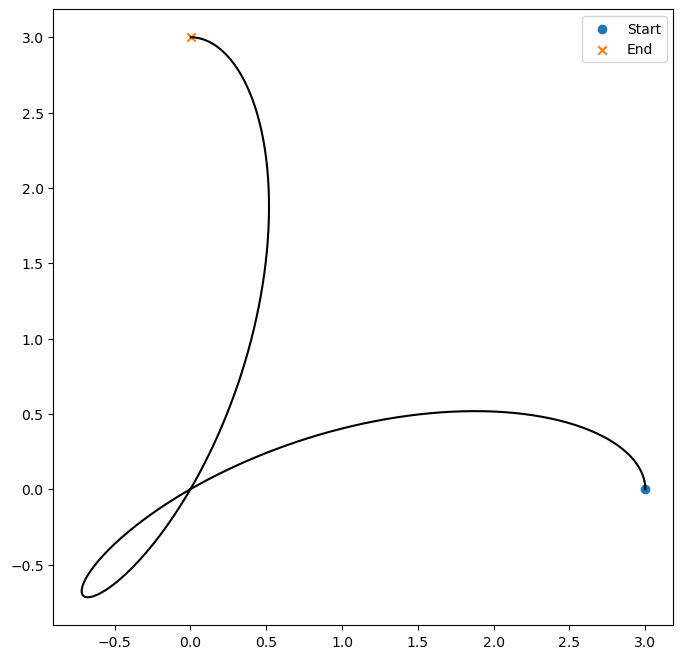

In [7]:
import matplotlib.pyplot as plt
# # You need the below line only if you're using this inside a Jupyter notebook.
# %matplotlib inline

plt.figure(figsize=(8,8))
plt.plot(trajectory[:,0,0],trajectory[:,0,1],color='black')
plt.scatter(trajectory[0,0,0],trajectory[0,0,1],marker='o',label='Start')
plt.scatter(trajectory[-1,0,0],trajectory[-1,0,1],marker='x',label='End')
plt.legend(loc='best')
plt.show()